# MFCC theory and implementation
## Theory
Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

## MEL scale
A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another [3] [4]. Because of how humans perceive sound the MEL scale is a non-lenear scale and the distances between the pitches increeses with frequency.

In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy import signal, ndimage
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

import librosa
import pywt

%matplotlib inline

In [3]:
_wav_file_ = "/home/riccardopasini/Documents/Aclai/Julia_additional_files/test.wav"
ipd.Audio(_wav_file_)

In [4]:
sr = 8000
audio, sample_rate = librosa.load(_wav_file_, sr=sr, mono=True)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 8000Hz
Audio duration: 3.528s


### Normalize audio

In [5]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

audio = normalize_audio(audio)

### Plot waveform

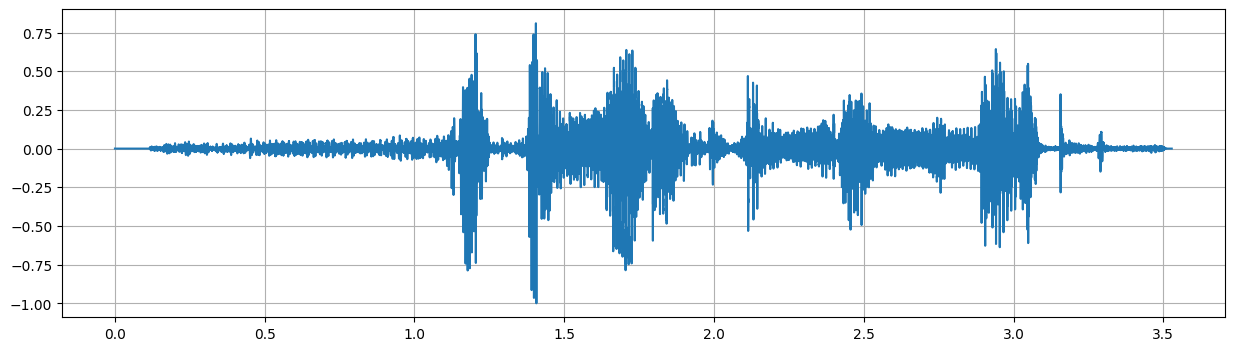

In [5]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

## Audio Framing
Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [6]:
def frame_audio(audio, FFT_size=1024, hop_size=10, sample_rate=44100):
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]

    print("Lunghezza totale in sample dell'audio:", len(audio))
    print("frame_len", frame_len)
    print("frame_num", frame_num)
    
    return frames

In [7]:
hop_size = 0.01
FFT_size = 512

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Lunghezza totale in sample dell'audio: 28736
frame_len 80
frame_num 353
Framed audio shape: (353, 512)


L'audio è stato diviso in finestre della dimensione FFT_size, e per coprire tutto l'audio servono tot finestre (il numero è definito dall'hop_size).
audio_framed è un array di vettori.

Now we have framed audio matrix with the size of frame number X FFT size.

In [8]:
print("First frame:")
audio_framed[0]

First frame:


array([ 5.98380429e-05, -5.98470760e-05,  5.98771803e-05, -5.98801926e-05,
        5.99524465e-05, -5.99795421e-05,  5.99976047e-05, -5.99915838e-05,
        6.00487838e-05, -6.00517960e-05,  6.00999629e-05, -6.01150168e-05,
        6.01601751e-05, -6.01872707e-05,  6.01902793e-05, -6.02384498e-05,
        6.02504915e-05, -6.02866203e-05,  6.03227454e-05, -6.03468288e-05,
        6.03558619e-05, -6.04040324e-05,  6.04040324e-05, -6.04853158e-05,
        6.04762827e-05, -6.05184323e-05,  6.05455280e-05, -6.05605819e-05,
        6.05696114e-05, -6.05936948e-05,  6.06539070e-05, -6.06749818e-05,
        6.07141192e-05, -6.07472357e-05,  6.07532565e-05, -6.07984148e-05,
        6.08164773e-05, -6.08736809e-05,  6.09007730e-05, -6.08827104e-05,
        6.09489434e-05, -6.09670060e-05,  6.09941017e-05, -6.10211973e-05,
        6.10663556e-05, -6.10874267e-05,  6.11145224e-05, -6.11446303e-05,
        6.11717260e-05, -6.11988216e-05,  6.12469885e-05, -6.12409713e-05,
        6.12951553e-05, -

In [9]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 3.61726945e-03,  5.41064329e-03,  3.46276700e-03,  7.98417628e-03,
        1.38220973e-02,  1.52992653e-02,  1.48867937e-02,  9.05698258e-03,
        1.30129354e-02,  1.29670659e-02,  1.15355114e-02,  7.30283652e-03,
       -3.88727523e-04, -5.31412475e-03, -6.63358718e-03, -3.13462410e-03,
        3.43053578e-03,  3.33850883e-04, -1.09045475e-03, -4.20189742e-03,
       -7.50742853e-03, -1.25221433e-02, -1.34773031e-02, -1.09519484e-02,
       -1.01407720e-02, -6.60875626e-03, -1.11257634e-03, -3.03761475e-03,
       -5.97130740e-03, -1.42332120e-02, -1.11103440e-02, -4.31359559e-03,
        4.46071895e-03,  1.72373541e-02,  1.21533126e-02,  6.37664739e-03,
        1.62034470e-03,  5.11546619e-04,  5.17387118e-04, -6.88046869e-03,
       -1.21535538e-02, -8.38319119e-03, -4.47738543e-03,  1.48505278e-04,
       -4.59590275e-03,  1.38404826e-03,  4.49066795e-03,  2.33931653e-03,
        4.26317449e-04,  9.38582141e-03,  1.48882866e-02,  1.60085335e-02,
        5.09207742e-03, -

## Convert to frequency domain
Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window. [7]

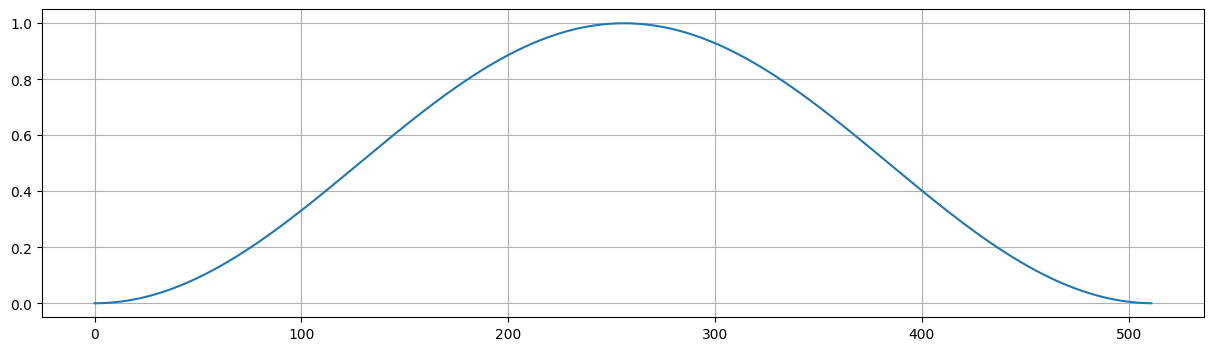

In [10]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

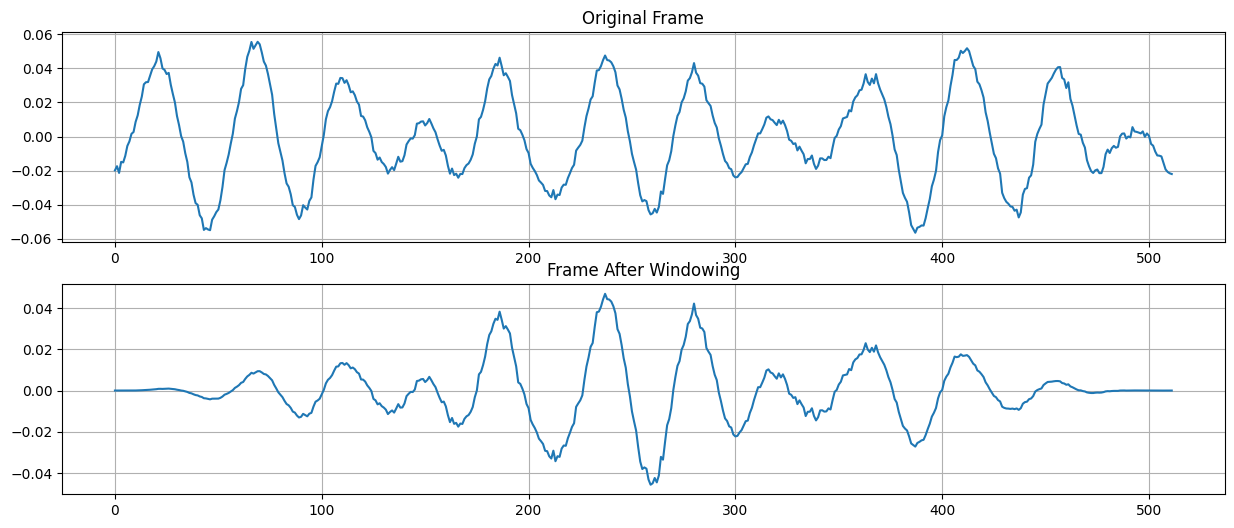

In [11]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

## Continuous Wavelet Transform

In [14]:
def cwt_spectrogram(audio, fs, nNotes=12):
    
    N = len(audio)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(audio,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi

    return power, times, frequencies, coif

# cwt_power, times, frequencies, coif = cwt_spectrogram(audio, sample_rate, nNotes=24)

In [17]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    # audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
    cwt_w_power, cwt_w_times, cwt_w_freq, cwt_w_coif = cwt_spectrogram(audio_winT[:, n], sample_rate)
    print(cwt_w_power)
    audio_fft[:, n] = cwt_w_power

audio_fft = np.transpose(audio_fft)

[[2.38813434e-16 4.21858670e-16 8.57453791e-16 ... 1.71861005e-15
  9.17579425e-16 5.65199342e-16]
 [2.29696846e-16 4.02829610e-16 8.13246990e-16 ... 1.57302634e-15
  8.44011167e-16 5.22810475e-16]
 [2.06141252e-16 3.57338386e-16 7.13567065e-16 ... 1.32802324e-15
  7.20634220e-16 4.51973091e-16]
 ...
 [1.34466941e-09 1.34580567e-09 1.34866130e-09 ... 1.44092640e-09
  1.43741172e-09 1.43529682e-09]
 [8.33190874e-10 8.33319070e-10 8.34253909e-10 ... 9.35862102e-10
  9.33453106e-10 9.32053791e-10]
 [5.60668983e-10 5.60246272e-10 5.60133620e-10 ... 6.65858766e-10
  6.63963686e-10 6.62893201e-10]]


ValueError: could not broadcast input array from shape (96,512) into shape (257,)

In [53]:
audio_fft.shape

(353, 257)

### Calculate signal power

In [54]:
fft_power = np.square(np.abs(audio_fft))
print(fft_power.shape)

(353, 257)


In [73]:
print(cwt_power.shape)

(312, 28224)


### variabili usate per creare le finestre per provare a fargli vedere la cwt

In [13]:
FFT_size = 1024

## MEL-spaced filterbank
Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [55]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 128

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 4000.0


### Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

This process is shown in the picture below:

<a href="https://ibb.co/kCsp4H"><img src="https://preview.ibb.co/hrFnrx/MEL.png" alt="MEL" border="0" /></a>

In [56]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [57]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=16000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [58]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
filter_points

MEL min: 0.0
MEL max: 2146.06452750619


array([  0,   0,   1,   2,   2,   3,   4,   4,   5,   6,   7,   7,   8,
         9,  10,  11,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  21,  22,  23,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  36,  37,  38,  39,  41,  42,  43,  44,  46,  47,  49,  50,
        51,  53,  54,  56,  57,  59,  60,  62,  63,  65,  67,  68,  70,
        72,  74,  75,  77,  79,  81,  83,  85,  86,  88,  90,  92,  94,
        97,  99, 101, 103, 105, 107, 110, 112, 114, 117, 119, 122, 124,
       127, 129, 132, 134, 137, 140, 143, 145, 148, 151, 154, 157, 160,
       163, 166, 169, 172, 176, 179, 182, 186, 189, 193, 196, 200, 203,
       207, 211, 215, 219, 222, 226, 230, 235, 239, 243, 247, 252, 256])

### Construct the filterbank
After we have the filter points, we construct the filters.

In [59]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

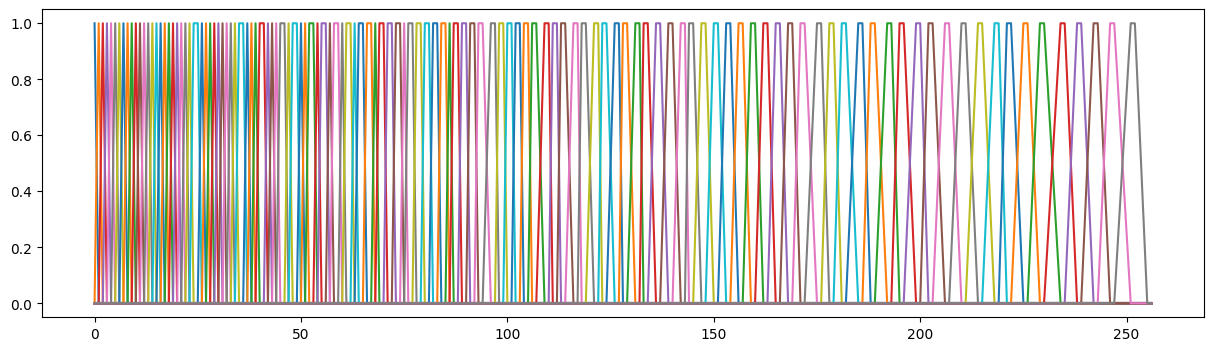

In [60]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.

In [61]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

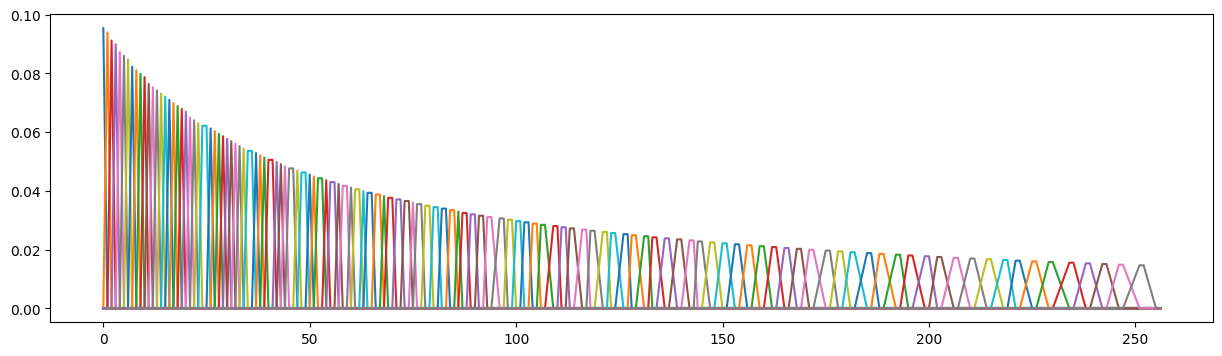

In [62]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

## Filter the signal

### fft

In [75]:
audio_filtered = np.dot(filters, np.transpose(fft_power))
audio_log = 10.0 * np.log10(audio_filtered)

print("filters shape:", filters.shape)
print("fft_power shape:", fft_power.shape)
print("audio_log shape", audio_log.shape)

filters shape: (128, 257)
fft_power shape: (353, 257)
audio_log shape (128, 353)


/tmp/ipykernel_3829/3661818058.py:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


## continous wavelet

In [74]:
audio_filtered = np.dot(filters, np.transpose(cwt_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

ValueError: shapes (128,257) and (28224,312) not aligned: 257 (dim 1) != 28224 (dim 0)

Now we have a matrix represemting the audio power in all 10 filters in different time frames.
## Generate the Cepstral Coefficents
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal [8] [9].

In [26]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [27]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

NameError: name 'audio_log' is not defined

## Reviewing Cepstral coefficents

In [25]:
cepstral_coefficents[:, 0]

array([-1.01131820e+02,  2.80576133e+01,  1.68256732e+01,  1.69483973e+01,
        1.06552247e+01,  6.92438362e+00,  3.68213425e+00,  1.80064840e+00,
        1.23812148e+00,  3.06621813e-01,  1.65146999e-13, -3.06621813e-01,
       -1.23812148e+00, -1.80064840e+00, -3.68213425e+00, -6.92438362e+00,
       -1.06552247e+01, -1.69483973e+01, -1.68256732e+01, -2.80576133e+01,
        1.43021992e+02, -2.80576133e+01, -1.68256732e+01, -1.69483973e+01,
       -1.06552247e+01, -6.92438362e+00, -3.68213425e+00, -1.80064840e+00,
       -1.23812148e+00, -3.06621813e-01, -4.31574271e-14,  3.06621813e-01,
        1.23812148e+00,  1.80064840e+00,  3.68213425e+00,  6.92438362e+00,
        1.06552247e+01,  1.69483973e+01,  1.68256732e+01,  2.80576133e+01])

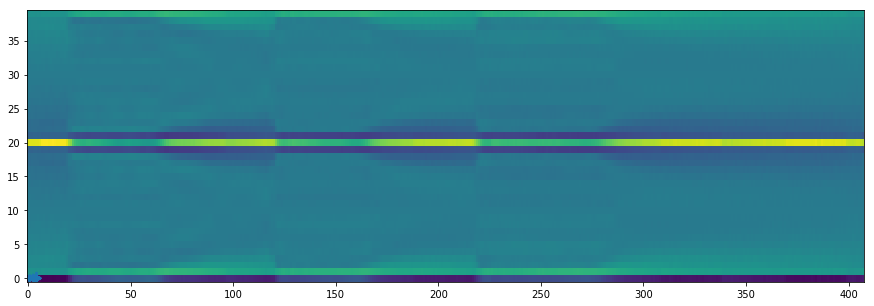

In [26]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

# Conclution
The MFCC is a good algorithm to extract high frequency and low frequency information. There are many parts that can be changed depending on the application. One thing that we might want to check is how the power is scattered across frequency band and choosing the filter amount based on that.

# Bibliography
[1] https://en.wikipedia.org/wiki/Voice_frequency

[2] https://en.wikipedia.org/wiki/Hearing_range

[3] https://www.sfu.ca/sonic-studio/handbook/Mel.html

[4] https://en.wikipedia.org/wiki/Mel_scale

[5] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

[6] https://librosa.github.io/librosa/

[7] https://en.wikipedia.org/wiki/Window_function#Hamming_window

[8] https://www.youtube.com/watch?v=Q2aEzeMDHMA

[9] https://en.wikipedia.org/wiki/Discrete_cosine_transform